In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

%matplotlib inline

In [2]:
train_df = pd.read_csv('../data/processed/train.csv')
print('shape: ', train_df.shape)
print('columns', train_df.columns)

shape:  (20631, 68)
columns Index(['id', 'cycle', 'setting1', 'setting2', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's20', 's21', 'RUL', 'label1', 'label2', 'avg_setting1',
       'std_setting1', 'avg_setting2', 'std_setting2', 'avg_s1', 'std_s1',
       'avg_s2', 'std_s2', 'avg_s3', 'std_s3', 'avg_s4', 'std_s4', 'avg_s5',
       'std_s5', 'avg_s6', 'std_s6', 'avg_s7', 'std_s7', 'avg_s8', 'std_s8',
       'avg_s9', 'std_s9', 'avg_s10', 'std_s10', 'avg_s11', 'std_s11',
       'avg_s12', 'std_s12', 'avg_s13', 'std_s13', 'avg_s14', 'std_s14',
       'avg_s15', 'std_s15', 'avg_s16', 'std_s16', 'avg_s17', 'std_s17',
       'avg_s20', 'std_s20', 'avg_s21', 'std_s21'],
      dtype='object')


In [3]:
test_df = pd.read_csv('../data/processed/test.csv')
print('shape: ', test_df.shape)
print('columns', test_df.columns)

shape:  (13096, 68)
columns Index(['id', 'cycle', 'setting1', 'setting2', 's1', 's2', 's3', 's4', 's5',
       's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's20', 's21', 'RUL', 'label1', 'label2', 'avg_setting1',
       'std_setting1', 'avg_setting2', 'std_setting2', 'avg_s1', 'std_s1',
       'avg_s2', 'std_s2', 'avg_s3', 'std_s3', 'avg_s4', 'std_s4', 'avg_s5',
       'std_s5', 'avg_s6', 'std_s6', 'avg_s7', 'std_s7', 'avg_s8', 'std_s8',
       'avg_s9', 'std_s9', 'avg_s10', 'std_s10', 'avg_s11', 'std_s11',
       'avg_s12', 'std_s12', 'avg_s13', 'std_s13', 'avg_s14', 'std_s14',
       'avg_s15', 'std_s15', 'avg_s16', 'std_s16', 'avg_s17', 'std_s17',
       'avg_s20', 'std_s20', 'avg_s21', 'std_s21'],
      dtype='object')


### Feature Selection

In [4]:
# Select feature columns
features = test_df.columns
features = features[(features != 'id') & (features != 'RUL') & (features != 'label1') & (features != 'label2')]

target = 'RUL'

In [5]:
def select_best_features_using_random_forest(X, y, k_best=None):
    rf = RandomForestRegressor(n_estimators=20, max_depth=4)
    scores = []
    for feature_name in X.columns:
        score = cross_val_score(rf, X[:][[feature_name]], y, scoring="r2", cv=ShuffleSplit(3, .3, random_state=42))
        scores.append((round(np.mean(score), 3), feature_name))
        
    scores = sorted(scores, key=lambda x: x[0], reverse=True)
    if k_best is None:
        return scores
    else:
        return scores[:k_best]


scores = select_best_features_using_random_forest(train_df[features], train_df[target], k_best=30)
best_features = [x[1] for x in scores]

### Modelling

In [6]:
X = train_df[best_features].values
y = train_df[target].values

# normalize data (we haven't ensured that MinMaxScaler is the best scaler for our data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [7]:
def plot_learning_curve_regression(model, title, X, y, scoring, cv=10, n_jobs=-1):
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = cv, test_size = 0.2, random_state = 0)
    # Create 10 KFold cross-validation sets
    #cv = cv

    # Generate the training set sizes increasing by 5%
    train_sizes = np.linspace(.1, 1.0, 5)
    
    # Note: Scoring parameter is needed to have proper scale 
    #       and values on the y scale.
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    #print("Train sizes:", train_sizes)
    #print("Train scores:", train_scores)
    #print("Test scores:", test_scores)
    
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Number of training examples")
    plt.ylabel("Score: " + scoring)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing score")

    plt.legend(loc="best")
    return plt, test_scores


def train_and_predict(model, X, y, loss_function, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    return loss_function(y_test, y_pred)


def train_and_cross_val_score(model, X, y, scoring, cv=10):
    return cross_val_score(model, X, y, scoring=scoring, cv=cv)


def train_predict_learning_curve(models, X, y, cv=10):
    for name, model in models:
        print("\nModel: ", name)
        score = (-1)*train_and_predict(model, X, y, loss_function=mean_absolute_error, test_size=0.2)
        print("Mean absolute error: %0.2f (+/- %0.2f)" % (score, score.std()))
        
        scoring = 'neg_mean_absolute_error'
        scores = train_and_cross_val_score(model, X, y, scoring, cv)
        #print("CV scores: ", scores)
        print("Mean absolute error (cross val.): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

        plt, scores = plot_learning_curve_regression(model, "Learning Performances ({0})".format(name), 
                                             X, y, scoring, cv=cv)
        last_scores = scores[-1]
        print("Mean absolute error (last learning perf.): %0.2f (+/- %0.2f)" % (last_scores.mean(), last_scores.std()))
        plt.show();

### Regression

#### Dummy Regressor


Model:  dummy-mean
Mean absolute error: -55.88 (+/- 0.00)
Mean absolute error (cross val.): -56.95 (+/- 6.34)
Mean absolute error (last learning perf.): -56.52 (+/- 0.47)


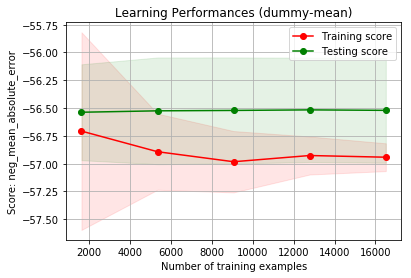


Model:  dummy-median
Mean absolute error: -55.69 (+/- 0.00)
Mean absolute error (cross val.): -56.79 (+/- 6.70)
Mean absolute error (last learning perf.): -56.39 (+/- 0.51)


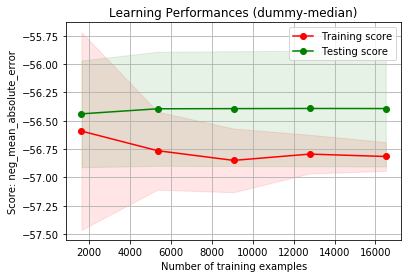

In [8]:
models = [
    ('dummy-mean', DummyRegressor(strategy='mean')),
    ('dummy-median', DummyRegressor(strategy='median'))
]

train_predict_learning_curve(models, X, y)

#### Decision Tree Regression

In [9]:
# Finding best model in a stochastic way
def objective(space):
    
    params = {
        'criterion': space['criterion'],
        'max_depth': space['max_depth'],
        'max_features': space['max_features'],
        'max_leaf_nodes': space['max_leaf_nodes'],
        'min_impurity_decrease': space['min_impurity_decrease'],
        'min_impurity_split': space['min_impurity_split'],
        'min_samples_leaf': space['min_samples_leaf'],
        'min_samples_split': space['min_samples_split'],
        'min_weight_fraction_leaf': space['min_weight_fraction_leaf'],
        'presort': space['presort'],
        'random_state': space['random_state'],
        'splitter': space['splitter']
    }
    
    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    loss = mean_absolute_error(y_test, y_pred)
    print("LOSS: {0}".format(loss))
    return{'loss':loss, 'status': STATUS_OK }
    
space = {    
    'criterion': 'mse', 
    'max_depth': hp.quniform ('max_depth', 1, 32, 1),
    'max_features': None,
    'max_leaf_nodes': None, 
    'min_impurity_decrease': 0.0,
    'min_impurity_split': None, 
    'min_samples_leaf': 1,
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 10, dtype=int)), 
    'min_weight_fraction_leaf': 0.0,
    'presort': False, 
    'random_state': 42, 
    'splitter': 'best'
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)
print("\nThe best params:\n", space_eval(space, best_params))

# check model performance for the best set of parameters
best_model = DecisionTreeRegressor(**space_eval(space, best_params))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("The LOSS the best params: ", mean_absolute_error(y_test, y_pred))

LOSS: 23.683604155361834
LOSS: 25.42405993430763
LOSS: 23.633462563605526
LOSS: 23.329718924157984
LOSS: 24.072253856715935
LOSS: 23.410454079081745
LOSS: 23.574615445656203
LOSS: 23.860835150634035
LOSS: 23.696881403729055
LOSS: 23.017230253780305

The best params:
 {'criterion': 'mse', 'max_depth': 12.0, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 42, 'splitter': 'best'}
The LOSS the best params:  23.017230253780305



Model:  best Decision Tree model
Mean absolute error: -23.02 (+/- 0.00)
Mean absolute error (cross val.): -32.37 (+/- 5.30)
Mean absolute error (last learning perf.): -23.22 (+/- 0.46)


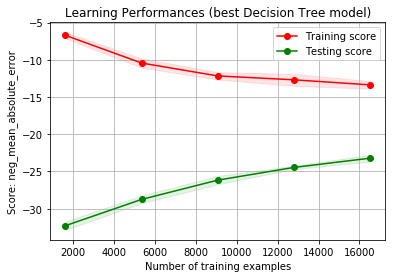

In [10]:
models = [
    ('best Decision Tree model', best_model)
]
train_predict_learning_curve(models, X, y, cv=5)

#### Random Forest Regression

In [11]:
# Finding best model in a stochastic way
def objective(space):
    
    params = {
        'bootstrap': space['bootstrap'], 
        'criterion': space['criterion'], 
        'max_depth': space['max_depth'],
        'max_features': space['max_features'], 
        'max_leaf_nodes': space['max_leaf_nodes'],
        'min_impurity_decrease': space['min_impurity_decrease'], 
        'min_impurity_split': space['min_impurity_split'],
        'min_samples_leaf': space['min_samples_leaf'], 
        'min_samples_split': space['min_samples_split'],
        'min_weight_fraction_leaf': space['min_weight_fraction_leaf'], 
        'n_estimators': space['n_estimators'], 
        'n_jobs': space['n_jobs'],
        'oob_score': space['oob_score'], 
        'random_state': space['random_state'], 
        'verbose': space['verbose'], 
        'warm_start': space['warm_start']
    }
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    loss = mean_absolute_error(y_test, y_pred)
    print("LOSS: {0}".format(loss))
    return{'loss':loss, 'status': STATUS_OK }
    
space = {    
    'bootstrap': True, 
    'criterion': 'mse', 
    'max_depth': hp.quniform ('max_depth', 1, 32, 1),
    'max_features': 'auto', 
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0, 
    'min_impurity_split': None,
    'min_samples_leaf': 1, 
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
    'min_weight_fraction_leaf': 0.0, 
    'n_estimators': hp.choice('n_estimators', np.arange(8, 32, dtype=int)), # number of trees 
    'n_jobs': -1, # use all CPU cores
    'oob_score': False, 
    'random_state': 42, 
    'verbose': 0, 
    'warm_start': False
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)
print("\nThe best params:\n", space_eval(space, best_params))

# check model performance for the best set of parameters
best_model = RandomForestRegressor(**space_eval(space, best_params))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("The LOSS the best params: ", mean_absolute_error(y_test, y_pred))

LOSS: 23.025838992775057
LOSS: 24.242155479843507
LOSS: 20.022879854547252
LOSS: 20.017686206887195
LOSS: 20.39891234220954
LOSS: 20.000336927358234
LOSS: 19.97814541657308
LOSS: 20.124671157265144
LOSS: 20.08387937719133
LOSS: 30.335339421041013

The best params:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 20.0, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 31, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
The LOSS the best params:  19.97814541657308



Model:  best Random Forest model
Mean absolute error: -19.98 (+/- 0.00)
Mean absolute error (cross val.): -27.54 (+/- 5.30)
Mean absolute error (last learning perf.): -20.09 (+/- 0.33)


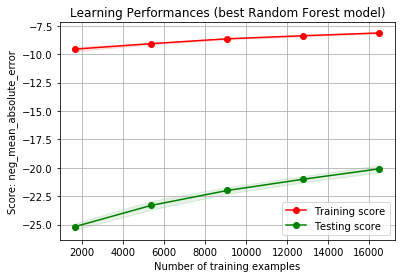

In [12]:
models = [
    ('best Random Forest model', best_model)
]
train_predict_learning_curve(models, X, y, cv=5)

#### Boosted Trees Regression

In [13]:
# Finding best model in a stochastic way
def objective(space):
    
    params = {
        'base_score': space['base_score'],
        'booster': space['booster'],
        'colsample_bylevel': space['colsample_bylevel'],
        'colsample_bytree': space['colsample_bytree'],
        'gamma': space['gamma'],
        'learning_rate': space['learning_rate'],
        'max_delta_step': space['max_delta_step'],
        'max_depth': space['max_depth'],
        'min_child_weight': space['min_child_weight'],
        'missing': space['missing'],
        'n_estimators': space['n_estimators'],
        'n_jobs': space['n_jobs'],
        'nthread': space['nthread'],
        'objective': space['objective'],
        'random_state': space['random_state'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'scale_pos_weight': space['scale_pos_weight'],
        'seed': space['seed'],
        'silent': space['silent'],
        'subsample': space['subsample']
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    loss = mean_absolute_error(y_test, y_pred)
    print("LOSS: {0}".format(loss))
    return{'loss':loss, 'status': STATUS_OK }
    
space = {    
    'base_score': 0.5, 
    'booster': 'gbtree', 
    'colsample_bylevel': 1,
    'colsample_bytree': 1, 
    'gamma': 0, 
    'learning_rate': 0.1, 
    'max_delta_step': 0,
    'max_depth': hp.choice('max_depth', np.arange(2, 16, dtype=int)), 
    'min_child_weight': 1, 
    'missing': None, 
    'n_estimators': hp.choice('n_estimators', np.arange(8, 100, dtype=int)), # number of trees,
    'n_jobs': -1, 
    'nthread': None, 
    'objective': 'reg:linear', 
    'random_state': 42,
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': 1, 
    'seed': None,
    'silent': True, 
    'subsample': 1
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)
print("\nThe best params:\n", space_eval(space, best_params))

# check model performance for the best set of parameters
best_model = XGBRegressor(**space_eval(space, best_params))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("The LOSS the best params: ", mean_absolute_error(y_test, y_pred))

LOSS: 24.320622233752914
LOSS: 24.320622233752914
LOSS: 23.91366226011077
LOSS: 24.532771324747436
LOSS: 19.89143478705746
LOSS: 19.815776928418018
LOSS: 21.725158804434102
LOSS: 17.782249685917577
LOSS: 17.78271754996263
LOSS: 17.782249685917577

The best params:
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 55, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
The LOSS the best params:  17.782249685917577



Model:  best XGBoost model
Mean absolute error: -17.78 (+/- 0.00)
Mean absolute error (cross val.): -28.09 (+/- 5.92)
Mean absolute error (last learning perf.): -18.33 (+/- 0.38)


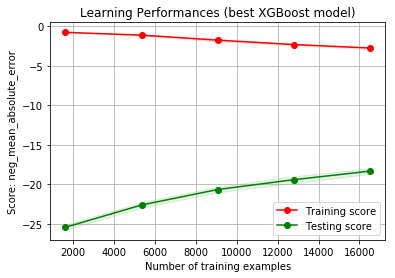

In [14]:
models = [
    ('best XGBoost model', best_model)
]
train_predict_learning_curve(models, X, y, cv=5)

In [15]:
# TODO:
# * get more familiar with XGBoost and available hyperparameters